# Communications

- Traccking, Telemetry, and Command (TT&C)
- USSF SCN: 1.76 - 1.84 GHz UL (L-band), 2.2-2.3 GHz (S-band)
- Unified S-Band: 2025 - 2110 MHz

$$
x=\pi
$$

In [1]:
from doop.constants import Earth, rad2deg, deg2rad
import numpy as np
from math import pi, log10
from matplotlib import pyplot as plt

In [2]:
from collections import namedtuple

In [241]:
P = 20
Ll = -1
Gt = 38.2
La = -0.3

# Fire Sat

LEO

SMAD, Ed 3 example page 567

In [242]:
# Space Loss
c = 3*10**8 # m/s
fs = 2.0*10**9 # Hz
S = 2831*10**3 # m
Lss = 10*log10((c/(4*pi*S*fs))**2)

fg = 2.2e9 # Hz
Lsg = 10*log10((c/(4*pi*S*fg))**2)
print(Lss, Lsg)

-167.50116948663035 -168.32902318979484


In [243]:
# antenna gain
def antennaGain(Dr,f, n):
    lamda = c/f # m
    return 10*log10((pi**2 * Dr**2 * n)/lamda**2)

Grpg = antennaGain(5.3, f, 0.55)
Grps = antennaGain(0.07, 2*10**9, 0.55)
print(f"Grp: Ground: {Grpg}  Space: {Grps}")

Lprg = -12*(.2/1.8)**2
Lprs = -12*(70/150)**2
print(f"Lpr: Ground: {Lprg}   Space: {Lprs}")

Grg = antennaGain(5.3, f, 0.55) + Lprg
Grs = antennaGain(0.07, 2*10**9, 0.55) + Lprs

print(f"Gr: Ground: {Grg}  Space: {Grs}")

# eqn 13-13
Rs = 100    # data rate [bps]
Tss = 614   # noise temp [K]
Ps = 1      # Power [W]
Lls = -1    # line loss [dB]
Las = -0.3  # prop/polar loss [dB]
Gts = 38.2  # net transmit antenna gain

Rg = 85e6    # data rate [bps]
Tsg = 135   # noise temp [K]
Pg = 20      # Power [W]
Llg = -1    # line loss [dB]
Lag = -0.3  # prop/polar loss [dB]
Gtg = 5.7  # net transmit antenna gain

K = -228.60 # boltzman const
ENs = 10*log10(Ps) + Lls + Gts + Lprs + Lss +Las + Grs - K - 10*log10(Tss) - 10*log10(Rs)
ENg = 10*log10(Pg) + Llg + Gtg + Lprg + Lsg +Las + Grg - K - 10*log10(Tsg) - 10*log10(Rg)
print(f"EN: Ground: {ENg}  Space: {ENs}")

Grp: Ground: 39.13817026289178  Space: 0.7267599679966283
Lpr: Ground: -0.14814814814814817   Space: -2.6133333333333333
Gr: Ground: 38.99002211474363  Space: -1.886573365336705
EN: Ground: 15.92562379134742  Space: 45.61724010328791


In [220]:
Link = namedtuple("Link","EN")

def linkBudget(f, P, Ll, thetat, et, S, Dr, er, R, BER, Ts, Gt):
    # f: frequency [Hz]
    # P: power [W]
    # Ll: line loss [dB]
    # thetat: transmit antenna beamwidth [deg]
    # et: transmit antenna pointing error [deg]
    # S: free space link [m]
    # Dr: receive antenna diameter [m]
    # er: receive antenna pointing error [deg]
    # R: data rate [bps]
    # BER: bit error rate
    # Ts: noise temp [K]
    
    # Space Loss
    c = 3*10**8 # m/s
    Ls = 10*log10((c/(4*pi*S*f))**2)
    n = 0.55
    Grp = antennaGain(Dr, f, n)
    thetar = -21/(f/1e9*Dr)
    Lpr = -12*(er/thetar)**2
    Gr = Grp + Lpr
    La = -0.3  # prop/polar loss [dB]
    K = -228.60 # boltzman const
    EN = 10*log10(P) + Ll + Gt + Lpr + Ls + La + Gr - K - 10*log10(Ts) - 10*log10(R)
    
    return Link(EN)

link = linkBudget(2.2e9, 20, -1, 32, 27, 2831e3,5.3,.2,85e6,10e-5,135, 5.7)

print(link) # 15.9 DL

Link(EN=15.925962318936257)


In [221]:
link = linkBudget(2.0e9, 1, -1, 2, .2, 2831e3,0.07,70,100,10e-5,614,38.2)

print(link) # 45.5 UL

Link(EN=45.61724010328791)


In [222]:
et=27
thetat = 32
Lpt = -12*(et/thetat)**2
Dt = 0.3
f = 2.2e9
n=0.55
Gpt = antennaGain(Dt,f,n)
Gt = Gpt +Lpt
print(Gpt, Lpt,Gt)

14.19507796526924 -8.54296875 5.65210921526924


In [244]:
class Antenna:
    def __init__(self, D,f, e,t, Ll=None, n=None):
        """
        D: diameter [m]
        f: frequency [Hz]
        e: pointing offset [deg]
        t: 3dB bandwidth [deg]
        Ll: Line loss [dBW], default is -1
        n: efficiency 0 - 1, default is 0.55
        """
        self.f = f
        self.D = D
        if Ll is None:
            Ll = -1
        elif Ll > 0:
            Ll = -Ll
        self.Ll = Ll
        if n is None:
            n = 0.55
        self.n = n
        self.Gp = self.antennaGain(f)
        self.pointingLoss = -12*(e/t)**2
        self.G = self.Gp + self.pointingLoss
        
    def antennaGain(self, f):
        c = 3e8     # m/s
        lamda = c/f # m
        return 10*log10((pi**2 * self.D**2 * self.n)/lamda**2)
    
    def patchAntennaGain(self):
        pass
    
    def eirp(self, P):
        """
        EIRP is a function of transmit power and transmit antenna gain;
        it makes no sense for a receiving antenna
        
        Ll: line loss between the transmitter and antenna feed [dB]
        """
        return 10*log10(P) + self.Ll + self.G
    
gu = Antenna(5.3,2e9,.2,2)
gd = Antenna(5.3,2.2e9,.2,1.8)
print(gu.G, gd.G)

asd = Antenna(.3,2.2e9,27,32)
asu = Antenna(.07,2e9,70,150)
print(asu.G, asd.G)

38.19031655972727 38.99002211474363
-1.886573365336705 5.65210921526924


In [238]:
gu.eirp(1)

37.19031655972727

In [239]:
asd.eirp(20)

17.662409171909054

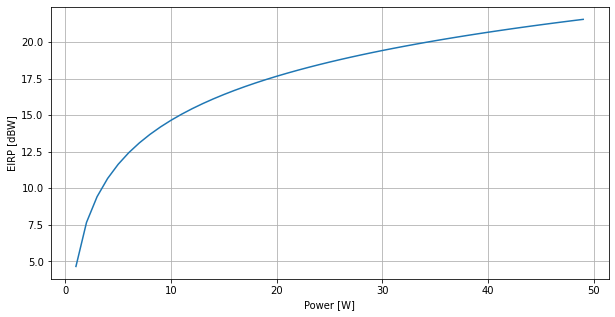

In [259]:
pwr = list(range(1, 50))
eirp = [asd.eirp(x) for x in pwr]

plt.figure(figsize=(10,5))
plt.plot(pwr, eirp)
plt.xlabel("Power [W]")
plt.ylabel("EIRP [dBW]")
plt.grid(True);

In [258]:
class LB:
    def __init__(self,tx,rx, S, P, R, Ts,La):
        """
        Calculates the RF link properties.
        
        tx: transmit antenna
        rx: receive antenna
        S: free space path range [m]
        P: transmit power [W]
        R: datarate [bps]
        Ts: 
        La: 
        """
        if tx.f != rx.f:
            raise Exception("mismatched frequencies")
        # self.S = S
        self.EN = self.linkBudget(tx.f, P, tx.Ll, S, R, Ts, tx.G, rx.Gp, La)
        
        # print(tr.G)
        # print(rv.G)
    
    def linkBudget(self,f, P, Ll, S, R, Ts, Gt, Gpr, La):
        # f: frequency [Hz]
        # P: power [W]
        # Ll: line loss [dB]
        # thetat: transmit antenna beamwidth [deg]
        # et: transmit antenna pointing error [deg]
        # S: free space link [m]
        # Dr: receive antenna diameter [m]
        # er: receive antenna pointing error [deg]
        # R: data rate [bps]
        # BER: bit error rate
        # Ts: noise temp [K]
        # print(f)

        # Space Loss
        c = 3e8 # m/s
        Ls = 10*log10((c/(4*pi*S*f))**2)
        # print(Ls)
        # n = 0.55
        # Grp = antennaGain(Dr, f, n)
        # Rg = 85e6    # data rate [bps]
        # Tsg = 135   # noise temp [K]
        # Llg = -1    # line loss [dB]
        # thetar = -21/(f/1e9*Dr)
        # Lpr = -12*(er/thetar)**2
        # Gr = Grp + Lpr
        # La = -0.3  # prop/polar loss [dB]
        k = 1.38064852e-23 # m^2 kg s^-2 K^-1
        K = 10*log10(k)
        # K = -228.60 # boltzman const
        self.EN = 10*log10(P) + Ll + Gt + Ls + La + Gpr - K - 10*log10(Ts) - 10*log10(R)
        self.CN = EN + 10*log10(R)
    
lb = LB(gu, asu, 2831e3,1,100,614,-0.3)
print(lb.EN, lb.CN)

print("\n----------\n")

ld = LB(asd, gd, 2831e3,20,85e6,135,-0.3)
print(ld.EN, ld.CN)

50.83339201277923 70.83339201277923

----------

16.173197986010337 95.46738724315327


# GEO

In [213]:
fg = 8e9 #2.25e9
Rg = 4e6 #256e3
Pg = 6

st = Antenna(.045,fg,2,10)
gr = Antenna(10,fg,.2,2)
print(st.G, st.eirp(Pg), gr.G)

8.450249269777611 15.231761773614048 55.74599899427074


In [214]:
link = LB(st, gr, Earth.geo*1000,Pg,Rg,135,-0.3)
print(link.EN)

8.950583833665007


In [167]:
Earth.geo

42164